## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [20]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import seaborn as sbn
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

%matplotlib inline

df = pd.read_csv('./kc_house_data.csv')

#### __Custom functions__

In [2]:
##################################
## Data Manipulation Functions ##
#################################
def find_null(df):
    return df[df.isnull().any(axis=1)]

def drop_columns (df, list_to_drop):
    """
    This function takes in a data frame and the list of labels, or columns to drop within the dataframe and returns a new dataframe
    with the drop columns removed

    df: Data frame or array type object
    list_to_drop: list of labels to remove from the frame object
    """
# to_drop = ['lat', 'long', 'view']
    drop_df = df.drop(list_to_drop, axis=1)
    return drop_df

##################################
## Graphing & Plotting function ##
##################################

def scatter_plot(X, Y, a=0.75, title='', x_label='', y_label=''):
        plt.title(title)
        plt.scatter(x=X, y=Y, alpha=a)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        plt.show()

def make_hist(df, col=[], figs=(15,15)):
    if not col:
        df.hist(figsize=figs)
    else:
        df.hist(figsize=figs, column=col)
    plt.show()
    
def scatter_matrix(df, alpha=0.75, color='g'):
    pd.plotting.scatter_matrix(df, figsize=(20,20), alpha=alpha, c=color)
    plt.show()
    
def heatmap(df):
    plt.figure(figsize=(20,20))
    sbn.heatmap(matrix.corr(), cmap=sbn.color_palette('Blues'), annot=True, fmt='0.2g')
    plt.show()

#####################################################
## Functions for transformations & feature scaling ##
#####################################################

def min_max2(srs):
    return (srs - min(srs))/(max(srs) - min(srs))

def min_max(df, lbl_col):
    return (df[lbl_col] - min(df[lbl_col]))/(max(df[lbl_col]) - min(df[lbl_col]))

def mean_norm2(srs):
    return (srs - np.mean(srs))/np.sqrt(np.var(srs))

def mean_norm(df, lbl_col):
    return (df[lbl_col] - np.mean(df[lbl_col]))/np.sqrt(np.var(df[lbl_col]))

def unit_vec2(srs):
    return (srs)/(np.linalg.norm(srs))

def unit_vec(df, lbl_col):
    return (df[lbl_col])/(np.linalg.norm(df[lbl_col]))

def log_trans2(srs):
    return np.log(srs)

def log_trans(df, lbl_col):
    return np.log(df[lbl_col])

##############################
## Feature Selection Method ##
##############################

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
           
    https://planspace.org/20150423-forward_selection_with_statsmodels/
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


#### ---End of custom function list---

In [3]:
# Get the dimensions of the data frame
# house_df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


## Data Cleaning

In this section, alterations are made to some of our data colums
* `sqft_basement` had values of `?` instead of a number.  These values were replaced with zeros
* `date` was converted to a date object and reassigned within the dataframe
* `yr_renovated` - _**year renovated**_ was dropped due to large ammounts of missing info & 0 for dates not listed
* Filled `NaN` & null values with -1. for `view` & `waterfront`  
   * This will be a sign that some info was not present

In [4]:
# Data cleaning for sqft_basement
df.sqft_basement.replace('?', 0, inplace=True)
df.sqft_basement = df.sqft_basement.astype('float')

# Convert date field to a date type
df['date'] = pd.to_datetime(df['date'])

# Fill null waterfront values with -1
df.waterfront.fillna(-1, inplace=True)

# Drop feature 'yr_renovated' since this column is missing a large ammount of data
df.drop(labels='yr_renovated', axis=1, inplace=True)

# Fill null view values with -1.  Retaining this info for later use
df.view.fillna(-1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11)
memory usage: 3.3 MB


## Data Conditioning 


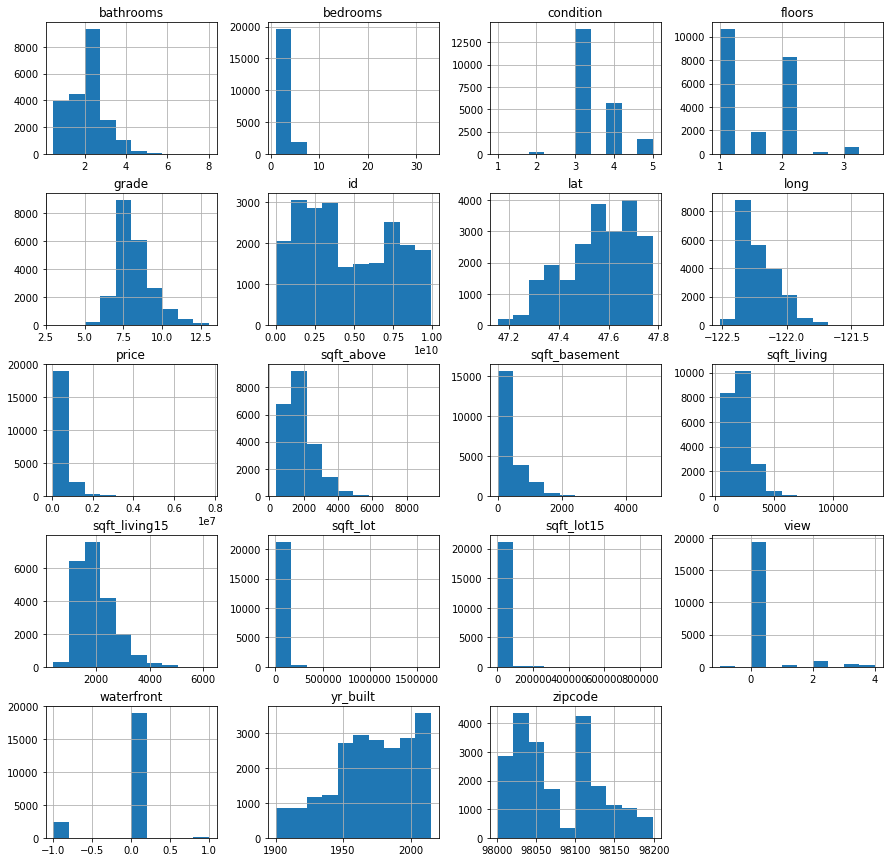

In [6]:
make_hist(df)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11)
memory usage: 3.3 MB


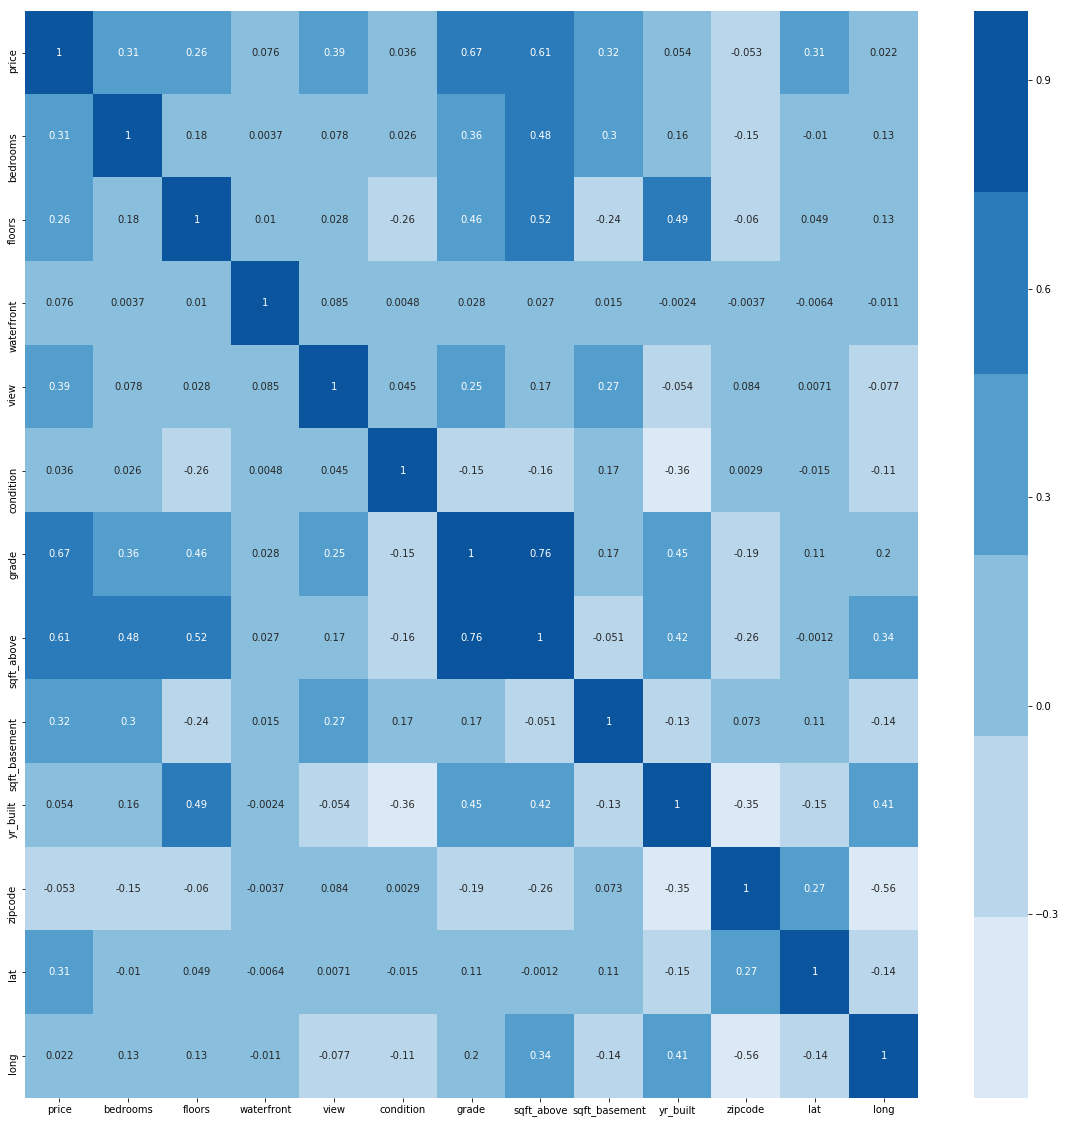

In [8]:
#Dropped sqft_living, since it had high multicolinearity with other features
to_drop = ['sqft_living15', 'sqft_living', 'sqft_lot15', 'date', 'id', 'sqft_lot', 'bathrooms']
matrix = drop_columns(df, to_drop)

heatmap(matrix)

In [9]:
abs(matrix.corr()) > 0.70

,price,bedrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long
price,True,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,True,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,True,False,False,False,False,False,False,False,False,False
view,False,False,False,False,True,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,True,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,True,True,False,False,False,False,False
sqft_above,False,False,False,False,False,False,True,True,False,False,False,False,False
sqft_basement,False,False,False,False,False,False,False,False,True,False,False,False,False
yr_built,False,False,False,False,False,False,False,False,False,True,False,False,False


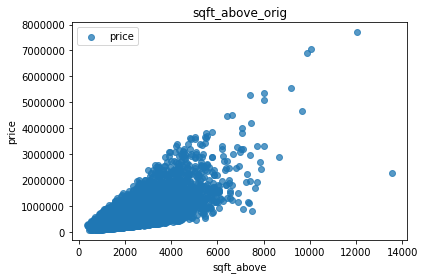

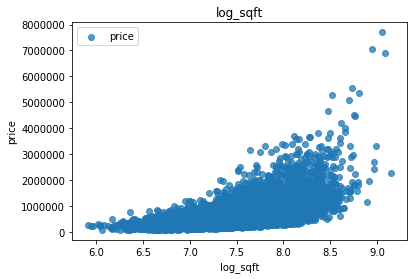

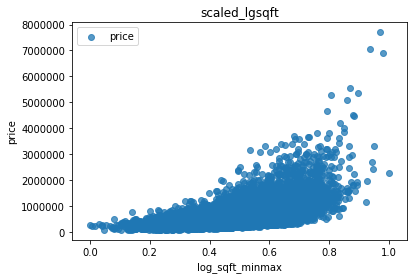

In [11]:
## Feature Transformations & Scaling ##
# log_sqft = log_trans2(matrix.sqft_above)
# scal_lsqft = min_max2(log_sqft)

# scatter_plot(df.sqft_living, df.price, title='sqft_above_orig', x_label='sqft_above', y_label='price')
# scatter_plot(log_sqft, df.price, title='log_sqft', x_label='log_sqft', y_label='price')
# scatter_plot(scal_lsqft, df.price, title='scaled_lgsqft', x_label='log_sqft_minmax', y_label='price')

## Model Creation & Validation

In this section, I have created several models, using different techniques to find the best combination of features with the least ammount of features dropped.

There are about 4 different techniques used here to select the best model with the most features possible.
    * Trial and error
    * Stepwise feature selection
    * Forward selection
    * Feature selection with recursive feature elimination

__Trial & Error: My personal features selection__

With this model, I chose to drop the following features:
**`sqft_living15`, `sqft_lot15`, `sqft_living`, `date`, `id`, `sqft_lot`, & `bathrooms`**

Most of these were dropped as a result of highly linear relations with other features.

**`Date` & `id`**  were removed mainly because they did not improve the information on houses themselves.                    
They were more similar to identifiers of the houses sold.

In [19]:
## My model with personally selected features. NO constant added ##
predictors = matrix.drop('price', axis=1)

# const = sm.add_constant(predictors)
model = sm.OLS(matrix['price'], predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 1.599e+04
Date:                Fri, 27 Sep 2019   Prob (F-statistic):               0.00
Time:                        08:41:54   Log-Likelihood:            -2.9508e+05
No. Observations:               21597   AIC:                         5.902e+05
Df Residuals:                   21585   BIC:                         5.903e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -3.201e+04   1905.931    -16.794      0.000   -3.57e+04   -2.83e+04
floors         1.753e+04   3444.241      5.089      0.000    1.08e+04    2.43e+04
waterfront     4.164e+04   4358.651      9.554      0.000    3.31e+04    5.02e+04
view           7.878e+04   2007.984     39.234      0.000    7.48e+04    8.27e+04
condition      2.732e+04   2364.972     11.552      0.000    2.27e+04     3.2e+04
grade          1.024e+05   2121.773     48.273      0.000    9.83e+04    1.07e+05
sqft_above      206.5754      3.192     64.717      0.000     200.319     212.832
sqft_basement   176.4763      4.002     44.098      0.000     168.632     184.320
yr_built      -2416.5045     63.003    -38.355      0.000   -2539.996   -2293.014
zipcode        -533.2158     17.932    -29.735      0.000    -568.365    -498.067
lat            6.013e+05    1.1e+04     54.530      0.000     5.8e+05    6.23e+05
long          -2.272e+05   1.31e+04    -17.289      0.000   -2.53e+05   -2.01e+05
==============================================================================
Omnibus:                    19028.698   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1962924.064
Skew:                           3.782   Prob(JB):                         0.00
Kurtosis:                      49.088   Cond. No.                     9.17e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.17e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
## My model with personally selected features AND constant added ##
predictors = matrix.drop('price', axis=1)

const = sm.add_constant(predictors)
model = sm.OLS(matrix['price'], const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     3826.
Date:                Fri, 27 Sep 2019   Prob (F-statistic):               0.00
Time:                        08:27:35   Log-Likelihood:            -2.9508e+05
No. Observations:               21597   AIC:                         5.902e+05
Df Residuals:                   21584   BIC:                         5.903e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.933e+06   2.96e+06      3.022      0.003    3.14e+06    1.47e+07
bedrooms      -3.227e+04   1907.570    -16.917      0.000    -3.6e+04   -2.85e+04
floors         1.983e+04   3526.698      5.623      0.000    1.29e+04    2.67e+04
waterfront     4.153e+04   4357.975      9.530      0.000     3.3e+04    5.01e+04
view           7.926e+04   2013.745     39.357      0.000    7.53e+04    8.32e+04
condition       2.63e+04   2388.289     11.014      0.000    2.16e+04     3.1e+04
grade          1.027e+05   2122.744     48.359      0.000    9.85e+04    1.07e+05
sqft_above      205.0122      3.233     63.412      0.000     198.675     211.349
sqft_basement   177.3107      4.011     44.210      0.000     169.449     185.172
yr_built      -2491.0267     67.645    -36.825      0.000   -2623.616   -2358.438
zipcode        -620.1586     33.896    -18.296      0.000    -686.596    -553.721
lat            6.021e+05    1.1e+04     54.597      0.000    5.81e+05    6.24e+05
long          -2.248e+05   1.32e+04    -17.076      0.000   -2.51e+05   -1.99e+05
==============================================================================
Omnibus:                    19026.377   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1967424.237
Skew:                           3.781   Prob(JB):                         0.00
Kurtosis:                      49.143   Cond. No.                     2.05e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
## Model using forward select functionality AND my selected features##
model_f = forward_selected(data=matrix, response='price')

print(model_f.model.formula)
model_f.summary()

price ~ grade + yr_built + sqft_above + sqft_basement + lat + view + bedrooms + condition + long + zipcode + waterfront + floors + 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     3826.
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        20:15:46   Log-Likelihood:            -2.9508e+05
No. Observations:               21597   AIC:                         5.902e+05
Df Residuals:                   21584   BIC:                         5.903e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      8.933e+06   2.96e+06      3.022      0.003    3.14e+06    1.47e+07
grade          1.027e+05   2122.744     48.359      0.000    9.85e+04    1.07e+05
yr_built      -2491.0267     67.645    -36.825      0.000   -2623.616   -2358.438
sqft_above      205.0122      3.233     63.412      0.000     198.675     211.349
sqft_basement   177.3107      4.011     44.210      0.000     169.449     185.172
lat            6.021e+05    1.1e+04     54.597      0.000    5.81e+05    6.24e+05
view           7.926e+04   2013.745     39.357      0.000    7.53e+04    8.32e+04
bedrooms      -3.227e+04   1907.570    -16.917      0.000    -3.6e+04   -2.85e+04
condition       2.63e+04   2388.289     11.014      0.000    2.16e+04     3.1e+04
long          -2.248e+05   1.32e+04    -17.076      0.000   -2.51e+05   -1.99e+05
zipcode        -620.1586     33.896    -18.296      0.000    -686.596    -553.721
waterfront     4.153e+04   4357.975      9.530      0.000     3.3e+04    5.01e+04
floors         1.983e+04   3526.698      5.623      0.000    1.29e+04    2.67e+04
==============================================================================
Omnibus:                    19026.377   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1967424.237
Skew:                           3.781   Prob(JB):                         0.00
Kurtosis:                      49.143   Cond. No.                     2.05e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
## Model using forward selected and main dataframe, with date & id features dropped ##
model_f = forward_selected(data=df.drop(labels=['date', 'id'], axis=1), response='price')

print(model_f.model.formula)
model_f.summary()

price ~ sqft_living + lat + view + grade + yr_built + bedrooms + bathrooms + zipcode + long + waterfront + sqft_above + condition + sqft_lot15 + sqft_living15 + sqft_basement + floors + sqft_lot + 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     2750.
Date:                Fri, 27 Sep 2019   Prob (F-statistic):               0.00
Time:                        08:27:58   Log-Likelihood:            -2.9494e+05
No. Observations:               21597   AIC:                         5.899e+05
Df Residuals:                   21579   BIC:                         5.901e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      8.305e+06      3e+06      2.767      0.006    2.42e+06    1.42e+07
sqft_living      99.8859     18.549      5.385      0.000      63.529     136.242
lat             5.94e+05    1.1e+04     53.954      0.000    5.72e+05    6.16e+05
view           7.688e+04   2030.585     37.863      0.000    7.29e+04    8.09e+04
grade          9.617e+04   2215.306     43.414      0.000    9.18e+04    1.01e+05
yr_built      -2773.8317     70.719    -39.223      0.000   -2912.446   -2635.218
bedrooms      -3.898e+04   1947.640    -20.016      0.000   -4.28e+04   -3.52e+04
bathrooms      4.394e+04   3324.169     13.217      0.000    3.74e+04    5.05e+04
zipcode        -597.3346     33.845    -17.649      0.000    -663.673    -530.996
long          -2.195e+05   1.35e+04    -16.266      0.000   -2.46e+05   -1.93e+05
waterfront     4.185e+04   4332.141      9.661      0.000    3.34e+04    5.03e+04
sqft_above       86.3087     18.537      4.656      0.000      49.975     122.643
condition      2.477e+04   2378.854     10.414      0.000    2.01e+04    2.94e+04
sqft_lot15       -0.3598      0.075     -4.780      0.000      -0.507      -0.212
sqft_living15    17.2893      3.535      4.891      0.000      10.360      24.218
sqft_basement    53.0170     18.374      2.885      0.004      17.002      89.032
floors         8527.9545   3691.243      2.310      0.021    1292.845    1.58e+04
sqft_lot          0.1018      0.049      2.071      0.038       0.005       0.198
==============================================================================
Omnibus:                    19159.525   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2035009.735
Skew:                           3.816   Prob(JB):                         0.00
Kurtosis:                      49.938   Cond. No.                     2.15e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
## Model using stepwise_selection with my personally selected features
results = stepwise_selection(predictors, matrix['price'], verbose = True)
print(f'Resulting features{results}')

Add  sqft_basement                  with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  lat                            with p-value 0.0
Add  view                           with p-value 0.0
Add  grade                          with p-value 0.0
Add  bedrooms                       with p-value 1.23001e-49
Add  condition                      with p-value 1.94812e-33
Add  long                           with p-value 1.64288e-27
Add  zipcode                        with p-value 3.74519e-71
Add  waterfront                     with p-value 1.69655e-21
Add  floors                         with p-value 1.90428e-08
Resulting features['sqft_basement', 'sqft_above', 'yr_built', 'lat', 'view', 'grade', 'bedrooms', 'condition', 'long', 'zipcode', 'waterfront', 'floors']


In [47]:
## Model using stepwise_selection with the date and id features dropped
#this line of code takes a long time to excecute. 

# result2 = stepwise_selection(df.drop(labels=['date', 'id'], axis=1), df['price'], verbose = True)
# print(f'Resulting features{results}')

In [14]:
## Feature ranking with recusive feature elimination using my selected features ##
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 12)
selector = selector.fit(predictors, matrix['price'])

selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [15]:
selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

[-3.22711713e+04  1.98292201e+04  4.15331637e+04  7.92552460e+04
  2.63038548e+04  1.02654069e+05  2.05012211e+02  1.77310738e+02
 -2.49102673e+03 -6.20158592e+02  6.02145314e+05 -2.24806997e+05]
8933465.190146275


In [17]:
## Feature ranking with recusive feature elimination using main data.  Dropped features: date & id ##
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 12)
selector = selector.fit(df.drop(labels=['date', 'id'], axis=1), df['price'])

selector.support_
# df[df.eq('?').any(1)]

array([ True,  True,  True, False, False,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True, False, False])

In [18]:
cols = df.drop(labels=['date', 'id'], axis=1).columns
for feat, rank in zip(cols, selector.ranking_):
    print(f'Feature: {feat} \t ranking: {rank}')
    
estimators = selector.estimator_

print(estimators.coef_)
print(estimators.intercept_)

Feature: price 	 ranking: 1
Feature: bedrooms 	 ranking: 1
Feature: bathrooms 	 ranking: 1
Feature: sqft_living 	 ranking: 4
Feature: sqft_lot 	 ranking: 6
Feature: floors 	 ranking: 1
Feature: waterfront 	 ranking: 1
Feature: view 	 ranking: 1
Feature: condition 	 ranking: 1
Feature: grade 	 ranking: 1
Feature: sqft_above 	 ranking: 3
Feature: sqft_basement 	 ranking: 2
Feature: yr_built 	 ranking: 1
Feature: zipcode 	 ranking: 1
Feature: lat 	 ranking: 1
Feature: long 	 ranking: 1
Feature: sqft_living15 	 ranking: 5
Feature: sqft_lot15 	 ranking: 7
[ 1.00000000e+00 -1.40111776e-11 -7.71079918e-12  5.00062088e-12
 -1.00417112e-11  3.01346341e-11 -1.11250686e-11  9.58248794e-12
 -1.74953276e-14 -8.96596092e-14  1.13926505e-11 -1.48112183e-11]
6.05359673500061e-09


### Cross Validation ##

In [53]:
cv_5_results = np.mean(cross_val_score(linreg, predictors, matrix['price'], cv=5, scoring="r2"))
cv_10_results = np.mean(cross_val_score(linreg, predictors, matrix['price'], cv=10, scoring="r2"))
cv_20_results = np.mean(cross_val_score(linreg, predictors, matrix['price'], cv=200, scoring="r2"))

print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

0.6768624054625596
0.6770367726403466
0.673102291599869


## EDA

In [ ]:
plt.figure(figsize=(10, 10))
sbn.violinplot(x='grade', y='price', data=df)
plt.show()

smf.OLS()

In [ ]:
def get_grade_group(grade):
    if grade <= 6:
        return 0
    if grade <= 10:
        return 1
    return 2

In [ ]:
df['grade_cat'] = df.grade.map(get_grade_group)

In [ ]:
plt.figure(figsize=(10, 10))
sbn.violinplot(data=df, x='grade_cat', y='price')
plt.show()

In [ ]:
# df['log_grade'] = log_trans(df, 'grade')

# df_g = df
# for col in df_g.columns:
#     if 'grade' not in col:
#         df_g.drop(labels=col, inplace=True)

scatter_plot(df.log_grade, df.price)

OLS = sm.OLS(df.price, df.log_grade).fit()
OLS.summary()

In [ ]:
sbn.distplot(df.sqft_living, fit=stats.norm)
OLS = sm.OLS(df.price, df.grade_cat).fit()
OLS.summary()

In [ ]:
make_hist(df, col=['grade_cat', 'grade', 'log_grade', 'price'], figs=(9,9))

scatter_plot(df.grade_cat, df.price)
scatter_plot(df.log_grade, df.price)
scatter_plot(df.grade, df.price)

In [ ]:
# pd.plotting.scatter_matrix(df, figsize=[15, 15])
# plt.fig
sbn.heatmap(df.corr(), center=0)

In [ ]:
# Program to identify if a house has more than one floor
# df.floors =  df.floors.apply(lambda x: )



In [ ]:
scatter_plot(X=df.sqft_living15, Y=df.grade, x_label= 'sqft_living', y_label='price',title='Grade per Price')

### Hexabin plot to include in data visuals.  This shows prices by lattitude & longitude

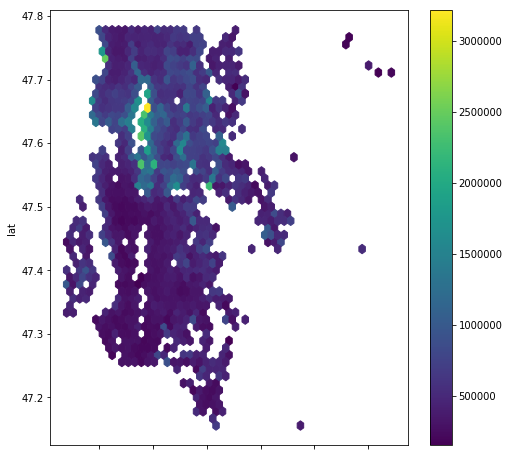

In [55]:
df.plot.hexbin(figsize=(8, 8), x='long', y='lat', C='price', gridsize=50, cmap='viridis')
plt.show()

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


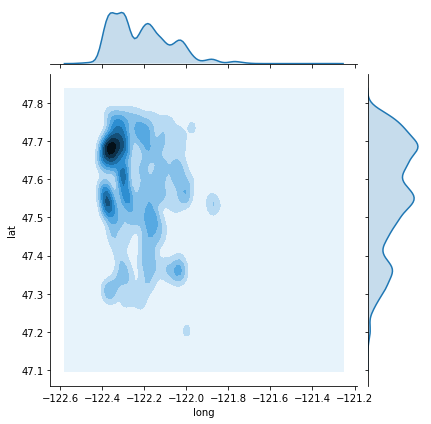

In [56]:
sbn.jointplot(x=df.long, y=df.lat, kind='kde')